In [1]:
import os
import sys

from pathlib import Path

# si aggiunge al path la cartella utils per avere visibilità del modulo
module_path = Path(os.getcwd()).parent.parent
module_path = os.path.join(module_path, "project-detective")

sys.path.append(module_path)

In [2]:
import cv2
import timm
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import utils.semi_hard_mining as shm

from torch import nn
from tqdm import tqdm
from skimage import io
from pathlib import Path
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [3]:
# serve per ricaricare automaticamente il codice modificato
%load_ext autoreload
%autoreload 2

In [4]:
# directory da dove vengono prelevate le immagini
path = Path(os.getcwd()).parent.parent
real_data_dir = os.path.join(path, "artifact", "coco")
fake_data_dir = os.path.join(path, "artifact", "taming_transformer")

# per far funzionare il modello su immagini rgb o in scala di grigi (per usare fourier)
mode="rgb"

BATCH_SIZE = 32

LR = 0.001

EPOCHS = 30

DEVICE = "cuda"

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")
print(f"cuDNN version: {torch.backends.cudnn.version()}")
print(f"Available devices: {torch.cuda.device_count()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.3.0+cu121
CUDA version: 12.1
cuDNN version: 8801
Available devices: 1
Device name: NVIDIA GeForce RTX 2050


In [5]:
csv_path = os.path.join("..", "datasets", "semi_hard_mining_database.csv")
df = pd.read_csv(csv_path)

df = df.sample(frac=1)

df.head()

train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

print(f"train dataset size: {len(train_df)}")
print(f"val dataset size: {len(valid_df)}")

train dataset size: 2068
val dataset size: 518


In [6]:
# carica le immagini nel dataset
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    
    if mode == "rgb":
      # le immagini Anchor sono memorizzate in due dataset diversi
      if "tt" in row.Anchor:
        A_img = io.imread(os.path.join(fake_data_dir, row.Anchor))
        P_img = io.imread(os.path.join(fake_data_dir, row.Positive))
        N_img = io.imread(os.path.join(real_data_dir, row.Negative))
      else:
        A_img = io.imread(os.path.join(real_data_dir, row.Anchor))
        P_img = io.imread(os.path.join(real_data_dir, row.Positive))
        N_img = io.imread(os.path.join(fake_data_dir, row.Negative))
          
      # normalizzazione per immagini in rgb 
      A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
      P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
      N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0

    if mode == "grey_scale":
      A_img = np.expand_dims(A_img, 0)
      P_img = np.expand_dims(P_img, 0)
      N_img = np.expand_dims(N_img, 0)
      
      A_img = torch.from_numpy(A_img) / 255.0
      P_img = torch.from_numpy(P_img) / 255.0
      N_img = torch.from_numpy(N_img) / 255.0

    # A_img = torch.from_numpy(A_img.astype(np.int32)) / 65536.0
    # P_img = torch.from_numpy(P_img.astype(np.int32)) / 65536.0
    # N_img = torch.from_numpy(N_img.astype(np.int32)) / 65536.0

    return A_img, P_img, N_img

In [7]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)
print(f"trainset size: {len(trainset)}")
print(f"validset size: {len(validset)}")

trainset size: 2068
validset size: 518


In [8]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [9]:
print(f"#batches in trainloader : {len(trainloader)}")
print(f"#batches in validloader : {len(validloader)}")

#batches in trainloader : 65
#batches in validloader : 17


In [10]:
# funzione per caricare il modello di rete neurale direttamente dalle repository online
class APN_Model_Pretrained(nn.Module):

  # size del vettore di embedding
  def __init__(self, emb_size = 512):
    super(APN_Model_Pretrained, self).__init__()

    # caricamento del modello, in questo caso efficientnet b0 (architettura più leggera della famiglia)
    self.efficientnet = timm.create_model("tf_efficientnetv2_b0", pretrained=True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [11]:
# funzione per caricare il modello di rete neurale direttamente dalle repository online
class APN_Model(nn.Module):

  # size del vettore di embedding
  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()

    # caricamento del modello, in questo caso efficientnet b0 (architettura più leggera della famiglia)
    self.efficientnet = timm.create_model("tf_efficientnetv2_b0", pretrained=False)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [12]:
model = APN_Model_Pretrained()

# per processare le immagini in scala di grigi per fare fourier serve una CNN 2D
if mode == "grey_scale":
    model.efficientnet.conv_stem = nn.Conv2d(1, 32, 3, 2, 1, bias=False)

model.to(DEVICE)

APN_Model_Pretrained(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
      )
      (1): Sequential(
        (0): EdgeResidual(
          (conv_exp): Conv2dSame(16, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (bn1): BatchNormAct2d(
            64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
      

In [13]:
# funzione di train
def train_fn(model, dataloader, optimizer, criterion):
  model.train()
  # on dropout 
  total_loss = 0.0

  for A, P, N in tqdm(dataloader, desc="model training..."):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    # qui vengono creati gli embeddings, le cui distanze verranno calcolate dopo
    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    # criterion è la funzione di loss triplet
    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)


In [14]:
# funzione di evaluation
def eval_fn(model, dataloader, criterion):
  model.eval() 
  # off dropout
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader, desc="model validating..."):
      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

  return total_loss / len(dataloader)

In [15]:
# triplet loss e adam
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [16]:
# training
best_valid_loss = np.Inf

training_epoch_loss = []
validation_epoch_loss = []


for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  training_epoch_loss.append(train_loss)
  validation_epoch_loss.append(valid_loss)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    best_valid_loss = valid_loss
    print("successful weights saving...")

  print(f"epochs: {i+1}, train_loss: {train_loss}, valid_loss: {valid_loss}")

model training...:   0%|          | 0/65 [00:00<?, ?it/s]C:\Users\acali\anaconda3\envs\fvabdetective\lib\site-packages\timm\layers\conv2d_same.py:27: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(x, weight, bias, stride, (0, 0), dilation, groups)
model validating...: 100%|██████████| 17/17 [00:11<00:00,  1.50it/s]


successful weights saving...
epochs: 1, train_loss: 0.6929798561793107, valid_loss: 0.5241909973761615


model validating...: 100%|██████████| 17/17 [00:09<00:00,  1.86it/s]


successful weights saving...
epochs: 2, train_loss: 0.2708795917721895, valid_loss: 0.4572942519889158


model validating...: 100%|██████████| 17/17 [00:08<00:00,  1.91it/s]


epochs: 3, train_loss: 0.1035574040733851, valid_loss: 0.46537760513670307


model validating...: 100%|██████████| 17/17 [00:08<00:00,  1.95it/s]


epochs: 4, train_loss: 0.11480176786963757, valid_loss: 0.557334006709211


model validating...: 100%|██████████| 17/17 [00:09<00:00,  1.82it/s]


epochs: 5, train_loss: 0.16546003978986007, valid_loss: 0.6580463726730907


model validating...: 100%|██████████| 17/17 [00:09<00:00,  1.76it/s]


epochs: 6, train_loss: 0.11570042257125561, valid_loss: 0.5981470995089587


model validating...: 100%|██████████| 17/17 [00:09<00:00,  1.87it/s]


successful weights saving...
epochs: 7, train_loss: 0.07359881492761465, valid_loss: 0.44754548195530386


model validating...: 100%|██████████| 17/17 [00:09<00:00,  1.88it/s]


epochs: 8, train_loss: 0.1709823502944066, valid_loss: 0.4897952298907673


model validating...: 100%|██████████| 17/17 [00:09<00:00,  1.86it/s]


epochs: 9, train_loss: 0.06597117804563962, valid_loss: 0.5786241661099827


model validating...: 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]


successful weights saving...
epochs: 10, train_loss: 0.06323742281932097, valid_loss: 0.40964174928034053


model validating...: 100%|██████████| 17/17 [00:08<00:00,  1.93it/s]


epochs: 11, train_loss: 0.022453756630420686, valid_loss: 0.4259486917187186


model validating...: 100%|██████████| 17/17 [00:09<00:00,  1.88it/s]


epochs: 12, train_loss: 0.02579550754565459, valid_loss: 0.4725642471629031


model validating...: 100%|██████████| 17/17 [00:09<00:00,  1.85it/s]


epochs: 13, train_loss: 0.05378923060802313, valid_loss: 0.6045092782553505


model validating...: 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]


epochs: 14, train_loss: 0.044524339586496355, valid_loss: 0.49979396690340605


model validating...: 100%|██████████| 17/17 [00:08<00:00,  1.90it/s]


epochs: 15, train_loss: 0.04297009637722602, valid_loss: 0.5958631459404441


model validating...: 100%|██████████| 17/17 [00:09<00:00,  1.88it/s]


epochs: 16, train_loss: 0.2181572194282825, valid_loss: 0.7458968986483181


model validating...: 100%|██████████| 17/17 [00:08<00:00,  1.98it/s]


epochs: 17, train_loss: 0.16519694465857285, valid_loss: 0.5592475901631748


model validating...: 100%|██████████| 17/17 [00:09<00:00,  1.87it/s]


epochs: 18, train_loss: 0.14055974956315298, valid_loss: 0.5622108236831778


model validating...: 100%|██████████| 17/17 [00:08<00:00,  1.94it/s]


epochs: 19, train_loss: 0.024239077361730428, valid_loss: 0.6021607763626996


model validating...: 100%|██████████| 17/17 [00:09<00:00,  1.89it/s]


epochs: 20, train_loss: 0.038550013303756715, valid_loss: 0.4571917407652911


model validating...: 100%|██████████| 17/17 [00:09<00:00,  1.86it/s]


epochs: 21, train_loss: 0.04189199151901098, valid_loss: 1.0110772725413828


model validating...: 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]


epochs: 22, train_loss: 0.04632850931240962, valid_loss: 0.6803092759321717


model validating...: 100%|██████████| 17/17 [00:08<00:00,  1.91it/s]


epochs: 23, train_loss: 0.013413717998908116, valid_loss: 0.6353309441576985


model validating...: 100%|██████████| 17/17 [00:09<00:00,  1.89it/s]


epochs: 24, train_loss: 0.005673911021305964, valid_loss: 1.1751040448160732


model validating...: 100%|██████████| 17/17 [00:09<00:00,  1.87it/s]


epochs: 25, train_loss: 0.0017921886191918299, valid_loss: 0.5974492378094617


model validating...: 100%|██████████| 17/17 [00:09<00:00,  1.86it/s]


epochs: 26, train_loss: 0.06444707541511609, valid_loss: 1.1673609579310698


model validating...: 100%|██████████| 17/17 [00:08<00:00,  1.97it/s]


epochs: 27, train_loss: 0.12108002981314292, valid_loss: 1.0043572853593266


model validating...: 100%|██████████| 17/17 [00:08<00:00,  1.92it/s]


epochs: 28, train_loss: 0.37276612783853824, valid_loss: 0.5079260030213524


model validating...: 100%|██████████| 17/17 [00:09<00:00,  1.87it/s]


epochs: 29, train_loss: 0.1140776283465899, valid_loss: 0.6536603605045992


model validating...: 100%|██████████| 17/17 [00:09<00:00,  1.88it/s]

epochs: 30, train_loss: 0.18313713669776915, valid_loss: 0.7039203117875492


<function matplotlib.pyplot.show(close=None, block=None)>

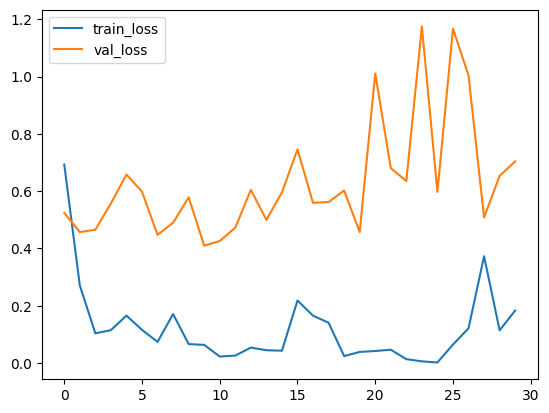

In [17]:
# plot della training e validation loss
plt.plot(training_epoch_loss, label="train_loss")
plt.plot(validation_epoch_loss, label="val_loss")
plt.legend()

plt.show

In [18]:
# funzione per generare i vettori di encoding
def get_encoding_csv(model, anc_img_names, dirFolder):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()

  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):

      if mode == "rgb":
        # serve per trovare correttamente l'immagine
        if "tt" in i:
          dirFolder = fake_data_dir
          A = io.imread(os.path.join(dirFolder,i))
        else: 
          dirFolder = real_data_dir
          A = io.imread(os.path.join(dirFolder,i))

        A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
      
      if mode == "grey_scale":
        A = io.imread(os.path.join(dirFolder,i))

        A = np.expand_dims(A, 0)
        A = torch.from_numpy(A.astype(np.int32)) / 255.0
        
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

    return df_enc

In [19]:
# per ricaricare il modello una volta allenato
model.load_state_dict(torch.load("best_model.pt"))

# si creano gli embeddings che vengono memorizzati per non rifarlo ad ogni allenamento
df_enc = get_encoding_csv(model, df["Anchor"], real_data_dir)

df_enc.to_csv("database.csv", index=False)

100%|██████████| 2586/2586 [01:03<00:00, 40.98it/s]


In [20]:
df_enc = pd.read_csv('database.csv')
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,tt-ffhq/ffhq_k300_p1.0_fid9.6/img006488.jpg,-0.538099,-0.011340,0.286294,0.074583,0.367632,0.142574,0.032318,-0.315532,0.216151,...,0.486385,-0.081615,-0.104507,0.159204,0.257111,0.178156,0.208934,-0.087246,-0.442888,0.026780
1,coco/coco2017/train2017/img129217.jpg,-0.593654,-0.097914,0.215335,-0.122665,0.508773,0.262276,0.167688,-0.262562,0.168730,...,0.276901,-0.225175,-0.084511,0.129068,0.340835,0.152230,-0.009651,0.013303,-0.493318,0.209872
2,tt-cc/cin_k600_p1.0_a0.05_fid5.20/542/img02466...,-1.043402,0.212216,0.291396,0.010277,0.317412,-0.071790,0.436998,-0.460643,-0.042455,...,0.316012,0.217033,-0.244823,0.252096,0.209835,0.164423,0.363211,-0.242136,-0.563124,0.241209
3,coco/coco2017/test2017/img000099.jpg,-0.710837,0.093663,0.319312,0.002496,0.515151,0.038476,0.168306,-0.287687,0.190928,...,0.444016,-0.015292,-0.109109,0.227264,0.247643,0.109931,0.374749,-0.060599,-0.454910,0.098403
4,coco/coco2017/test2017/img030796.jpg,-0.680354,-0.049902,0.268062,-0.008335,0.549080,-0.030951,0.224608,-0.143379,0.178372,...,0.239506,-0.171204,-0.117794,0.313864,0.267244,0.108903,0.257170,0.031303,-0.549013,0.315463


In [21]:
# approssimazione della distanza, senza la radice quadrata, per fare i primi allenamenti velocemente
def euclidean_dist(img_enc, anc_enc_arr):
    # dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T))
    dist = np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T)
    # dist = np.sqrt(dist)
    return dist

In [22]:
path = os.path.join(Path(os.getcwd()).parent, "datasets", "testList.csv")
df = pd.read_csv(path)

print(df["real"])
print(df.size)
df.head()

0      coco/coco2017/train2017/img045591.jpg
1      coco/coco2017/train2017/img084647.jpg
2      coco/coco2017/train2017/img115765.jpg
3      coco/coco2017/train2017/img131710.jpg
4      coco/coco2017/train2017/img059718.jpg
                       ...                  
512    coco/coco2017/train2017/img120761.jpg
513    coco/coco2017/train2017/img089908.jpg
514     coco/coco2017/test2017/img008408.jpg
515     coco/coco2017/test2017/img024968.jpg
516    coco/coco2017/train2017/img095503.jpg
Name: real, Length: 517, dtype: object
1034


,real,fake
0,coco/coco2017/train2017/img045591.jpg,tt-ffhq/ffhq_k300_p1.0_fid9.6/img003490.jpg
1,coco/coco2017/train2017/img084647.jpg,tt-coco/samples_nopix/img002132.jpg
2,coco/coco2017/train2017/img115765.jpg,tt-ffhq/ffhq_k300_p1.0_fid9.6/img021101.jpg
3,coco/coco2017/train2017/img131710.jpg,tt-cc/cin_k600_p1.0_a0.05_fid5.20/558/img02554...
4,coco/coco2017/train2017/img059718.jpg,tt-cc/cin_k600_p1.0_a0.05_fid5.20/979/img04888...


In [23]:
def getImageEmbeddings(img, model):
    if mode == "rgb":
        img = torch.from_numpy(img).permute(2, 0, 1) / 255.0
      
    if mode == "grey_scale":
        img = np.expand_dims(img, 0)
        img = torch.from_numpy(img) / 255
    
    model.eval()
    with torch.no_grad():
        img = img.to(DEVICE)
        img_enc = model(img.unsqueeze(0))
        img_enc = img_enc.detach().cpu().numpy()
        img_enc = np.array(img_enc)

    return img_enc

In [24]:
def searchInDatabase(img_enc, database):
    anc_enc_arr = database.iloc[:, 1:].to_numpy()
    anc_img_names = database["Anchor"]

    distance = []
    for i in range(anc_enc_arr.shape[0]):
        dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
        distance = np.append(distance, dist)

    closest_idx = np.argsort(distance)

    return database["Anchor"][closest_idx[0]]

In [25]:
# DataTestReal = 'C:/Users/polsi/Desktop/Lavori/DeepFake/Datasets/Artifact/cycle_gan/st/test/'
path = Path(os.getcwd()).parent.parent
real_data_dir = os.path.join(path, "artifact", "coco")
fake_data_dir = os.path.join(path, "artifact", "taming_transformer")

y_true = []
y_pred = []

tempDf = df
tempDf.head()
tempDf.shape

(517, 2)

In [26]:
# testo i fake
currentTest = "fake"
database = df_enc

# prendo i primi 500 Fake
for index, row in tqdm(tempDf.iterrows(), desc="testing on fake images..."):
    path = os.path.join(fake_data_dir, row[currentTest])
    img_name = path

    img = io.imread(img_name)

    img_enc = getImageEmbeddings(img, model)

    closestLabel = searchInDatabase(img_enc, database)

    if mode == "rgb":
        if str(closestLabel).startswith("tt"):
            y_pred.append("fake")
        else:
            y_pred.append("real")

    if mode == "grey_scale": 
        if "coco" in closestLabel:
            y_pred.append("real")
        else:
            y_pred.append("fake")

testing on fake images...: 517it [00:33, 15.47it/s]


In [27]:
print(len(y_true))
print(len(y_pred))
print(y_pred)

0
517
['fake', 'fake', 'real', 'fake', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'fake', 'fake', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'fake', 'real', 'real', 'real', 'real', 'real', 'fake', 'fake', 'real', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'real', 'fake', 'fake', '

In [28]:
# testo i real
currentTest = "real"
database = df_enc

# prendo i primi 500 Fake
for index, row in tqdm(tempDf.iterrows(), desc="testing on real images..."):
    path = os.path.join(real_data_dir, row[currentTest])
    img_name = path

    img = io.imread(img_name)

    img_enc = getImageEmbeddings(img, model)

    closestLabel = searchInDatabase(img_enc, database)
    
    if mode == "rgb":
        if "tt" in closestLabel:
            y_pred.append("fake")
            
        else:
            y_pred.append("real")

    if mode == "grey_scale": 
        if "real" in closestLabel:
            y_pred.append("real")
        else:
            y_pred.append("fake")


testing on real images...: 517it [00:35, 14.44it/s]


In [42]:
print(len(y_true))
print(len(y_pred))
print(y_pred)

1036
1034
['fake', 'fake', 'real', 'fake', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'fake', 'fake', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'fake', 'real', 'real', 'real', 'real', 'real', 'fake', 'fake', 'real', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'real', 'fake', 'fake

In [44]:
# creo i vettori di ground truth
y_true = np.array(["fake"] * 517)
print(y_true.shape)

temp = np.array(["real"] * 517)
print(temp.shape)

y_true = np.concatenate([y_true, temp])
print(y_true.shape)

# calcolo la matrice di confusione (quella di scikit-learn dispone i risultati come nella cella di sotto)
cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])
print(cm)

(517,)
(517,)
(1034,)
[[265 252]
 [298 219]]


In [45]:
TN, FP, FN, TP = cm.ravel()

# metriche
accuracy = round((TP + TN) / (TP + TN + FP + FN), 4) * 100
precision = round((TP) / (TP + FP), 4) * 100
recall = round((TP) / (TP + FN), 4) * 100
specificity = round((TN) / (TN + FP) * 100, 4)
f1_score = round((2 * precision * recall) / (precision + recall), 4)

print({"Accuracy":accuracy, "Precision":precision, "Recall":recall, "Specificity":specificity, "F1 Score":f1_score})

{'Accuracy': 46.81, 'Precision': 46.5, 'Recall': 42.36, 'Specificity': 51.2573, 'F1 Score': 44.3336}


In [46]:
# si salvano i risultati in un file .csv
df_results = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "Specificity", "F1 Score"])
df_results.loc[0] = [accuracy, precision, recall, specificity, f1_score]

# si differenziano i risultati in base al tipo di immagini e dataset usati
dataset = fake_data_dir.split("\\")[-1]
path = os.path.join("..", "results", "siamese_" + mode + "_" + dataset + "_results.csv")

df_results.to_csv(path, index=False)